*  Build Transfer learning model on ViT
*  Set all max_iter = 50
*  set all epsilon as 0.03 for all attacks that require it

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [2]:
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0


In [3]:
# pathh = 'MNISTClassifier'

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)

# os.rmdir('./MNISTClassifier')

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
# x_train, x_test = images, test_images
# y_train, y_test = labels, test_labels

In [5]:
train_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in train_images])
test_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in test_images])

In [6]:
print('x_train.shape', train_images.shape)
print('y_train.shape', train_images.shape)


x_train.shape (60000, 28, 28, 3)
y_train.shape (60000, 28, 28, 3)


In [7]:
train_images = np.asarray([cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in train_images])
test_images = np.asarray([cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in test_images])

In [8]:
x_test, y_test = test_images, test_labels

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=104, test_size=0.166655, shuffle=True)

In [10]:
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_val.shape', x_val.shape)
print('y_val.shape', y_val.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

x_train.shape (50000, 64, 64, 3)
y_train.shape (50000,)
x_val.shape (10000, 64, 64, 3)
y_val.shape (10000,)
x_test.shape (10000, 64, 64, 3)
y_test.shape (10000,)


(64, 64, 3)


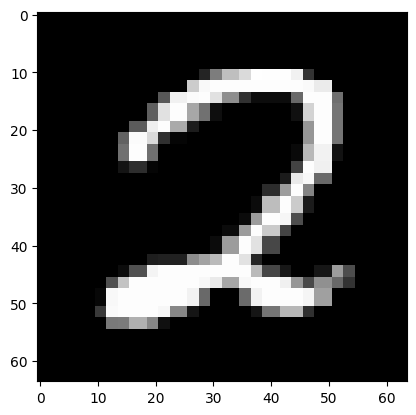

In [11]:
x_test_43 = x_test[35]

print(x_test_43.shape)
digit = x_test_43
fig = plt.figure
plt.imshow(digit)
# print(x_test_43)

#twos are located at [(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]

In [12]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 9:
    break
  if label == 2:
    few_twos.append((index, label))
    count += 1

print(few_twos)
#select labels that are digit 2

[(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]


# Networks

## Custom

In [13]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='sigmoid')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob

## Backbone Networks

In [14]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [15]:
class VGG16model(tf.keras.Model):
    def __init__(self, base_model):
        super(VGG16model, self).__init__()
        #instantiate base model
        self.base_model = base_model
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.base_model, self.flatten, self.dense1, self.dense2]

    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob
    

In [16]:
input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
base_model = VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
base_model.trainable = False



2024-03-22 10:10:12.585712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-22 10:10:12.585745: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-22 10:10:12.585751: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-22 10:10:12.585813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 10:10:12.585844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Model fit and saving

In [18]:
class SavefinalTrainingLogitsProp(keras.callbacks.Callback):
    def on_train_end(self, logs):
        self.out = model.predict(x_train)
        self.prob = tf.nn.softmax(self.out)
        print(self.out.shape, self.prob.shape)

In [19]:
def plot_loss_acc(train_metric_values, val_metric_values, type=None, plt_title=None):
    epochs = range(1, len(train_metric_values) +1)
    plt.plot(epochs, train_metric_values, 'bo', label=f'Training {type}')
    plt.plot(epochs, val_metric_values, 'b', label=f'validation {type}')
    plt.title(plt_title)
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.legend()
    plt.show()
    
    

In [20]:
model_custom = MNISTClassifier()
model_custom.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

custom_history = model_custom.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
# model_custom.save('MNISTClassifier')

Epoch 1/10


2024-03-22 10:10:20.026886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 16s 10ms/step - loss: 0.4722 - accuracy: 0.8729 - val_loss: 0.1980 - val_accuracy: 0.9517
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1657 - accuracy: 0.9606 - val_loss: 0.1178 - val_accuracy: 0.9679
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1133 - accuracy: 0.9728 - val_loss: 0.0949 - val_accuracy: 0.9725
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0890 - accuracy: 0.9780 - val_loss: 0.0818 - val_accuracy: 0.9758
Epoch 5/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.0751 - accuracy: 0.9806 - val_loss: 0.0726 - val_accuracy: 0.9782
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0659 - accuracy: 0.9825 - val_loss: 0.0674 - val_accuracy: 0.9793
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.0590 - accuracy: 0.9843 - val_loss: 0.0648 - val_accuracy: 0.

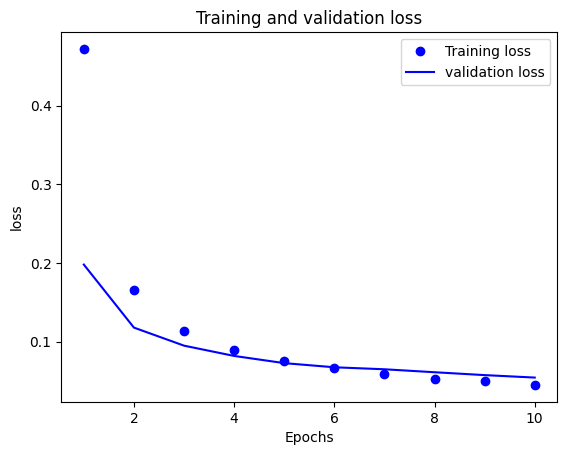

In [33]:
loss_values = custom_history.history["loss"]
val_loss_values = custom_history.history["val_loss"]
plot_loss_acc(loss_values, val_loss_values, type='loss',  plt_title="Training and validation loss")

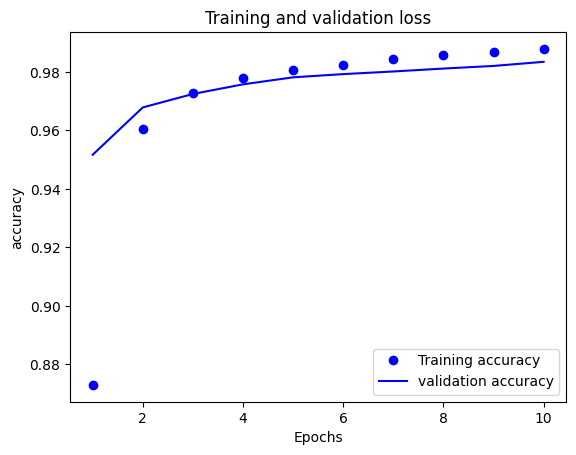

In [35]:
acc_values = custom_history.history["accuracy"]
val_acc_values = custom_history.history["val_accuracy"]
plot_loss_acc(acc_values, val_acc_values, type='accuracy',  plt_title="Training and validation loss")

In [22]:
model_vgg16 = VGG16model(base_model)
model_vgg16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

vgg16_history = model_vgg16.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
model_vgg16.save('VGG16Classifier')

Epoch 1/5


2024-02-26 10:26:22.967938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 36s 21ms/step - loss: 0.2225 - accuracy: 0.9415 - val_loss: 0.0959 - val_accuracy: 0.9706
Epoch 2/5
1563/1563 [==============================] - 32s 21ms/step - loss: 0.0765 - accuracy: 0.9771 - val_loss: 0.0681 - val_accuracy: 0.9790
Epoch 3/5
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0589 - accuracy: 0.9817 - val_loss: 0.0653 - val_accuracy: 0.9789
Epoch 4/5
1563/1563 [==============================] - 34s 21ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 0.0538 - val_accuracy: 0.9822
Epoch 5/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.0569 - val_accuracy: 0.9803
INFO:tensorflow:Assets written to: VGG16Classifier/assets


INFO:tensorflow:Assets written to: VGG16Classifier/assets


# Load model and make predictions

## prepare images and labels

In [36]:
twos_tupple = [(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]
reshaped_sample_twos = []
class_arr = []

for tup in twos_tupple:
    a_two = x_test[tup[0]]
    print('a_two.shape', a_two.shape)
    a_two = np.reshape(a_two, (-1, 64, 64, 3))
    print('a_two.shape', a_two.shape)
    a_two_label = y_test[tup[0]]
    a_two_label = tf.convert_to_tensor(a_two_label)
    class_arr.append(a_two_label)
    # print(a_two_label)
    reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)

a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)


In [37]:
print(y_test[35])

2


In [38]:
# model_mnist = tf.keras.models.load_model('MNISTClassifier')

predictions = []
for sample in reshaped_sample_twos:
    sample_prediction = model_custom.predict(sample)
    predictions.append(sample_prediction)
#check a prediction
print(np.argmax(predictions[1][0]))

1/1 [==============================] - 0s 9ms/step
2


In [39]:
print(reshaped_sample_twos[0].shape)
# drop first dimension (batch) and prepare for attack
squeze_two = np.squeeze(reshaped_sample_twos[2])
print(squeze_two.shape)
# squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[2]), axis=2)
# squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[35]
y = tf.convert_to_tensor(y)
print(y)
print(x.shape)

(1, 64, 64, 3)
(64, 64, 3)
tf.Tensor(2, shape=(), dtype=uint8)
(1, 64, 64, 3)


# Attack and Plot

In [78]:
def fgsm(model, x, y, eps=0.01, max_iter=50, verbose=False):
    y = tf.one_hot(y, 10)
    y = np.reshape(y, (1,10))
    y_pred = None

    x = tf.cast(x, tf.float32)
    for idx in range(max_iter):
        with tf.GradientTape() as tape:
            tape.watch(x)
            y_pred = model(x)
            #model returns two output during prediction logits and probabilities i.e softmax O/P
            y_pred = y_pred[1]
            loss = tf.keras.losses.categorical_crossentropy(y, y_pred, from_logits=True)

        gradient = tape.gradient(loss, x) #compute how change in the image variable affects the loss
        # gradient /= tf.math.reduce_std(gradient) + 1e-8
        signed_grad = tf.sign(gradient)
        perturbation = eps * signed_grad
        adv_x = x + perturbation
        adv_x = tf.clip_by_value(adv_x, 0, 1) #limits the values of the image matrix bw 0 and 1
        x = adv_x

        if verbose:
            if idx%10 == 0:
                print(f"Num_iterations: {num_iteration} \n Y_Pred: {np.argmax(y_pred)} \n Y: {np.argmax(y)}")
        if np.argmax(y_pred) != np.argmax(y):
            break

    return adv_x, perturbation
        
    

## Batch attack

In [79]:
def run_attacks(img_arr, class_arr, model, att_func):
    results = []
    for img, cls in zip(img_arr, class_arr):
        x_test_adv, perturbation = att_func(model, img, cls)
        results.append((x_test_adv, perturbation))
    return results
    

In [80]:
attack_results = run_attacks(reshaped_sample_twos, class_arr, model_custom, fgsm)

In [81]:
print(attack_results[0][0].shape)
adv_image = np.squeeze(attack_results[0][0])
# adv_image = np.expand_dims(adv_image, axis=2)
org_image = np.squeeze(reshaped_sample_twos[0])
perturbation = np.squeeze(attack_results[0][1])
org_image.shape
adv_image.shape
# plt.imshow(adv_image, cmap='gray')

(1, 64, 64, 3)


(64, 64, 3)

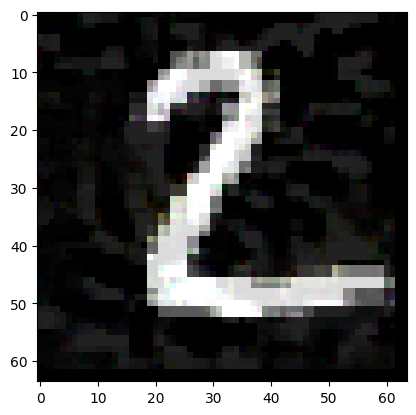

In [82]:
plt.imshow(adv_image, cmap='gray')

In [83]:
print(reshaped_sample_twos.shape)

(10, 1, 64, 64, 3)


In [84]:
xb = reshaped_sample_twos[0]
xb.shape

(1, 64, 64, 3)

In [85]:
x_test_adv, perturbation = fgsm(model_custom, reshaped_sample_twos[0], class_arr[0], 0.025)

In [86]:
# adv_image = np.squeeze(x_test_adv)
# adv_image = np.expand_dims(adv_image, axis=2)
# org_image = np.expand_dims(np.squeeze(xb), axis=2)
# perturbation = np.expand_dims(np.squeeze(perturbation), axis=2)
# org_image.shape
# adv_image.shape
# plt.imshow(adv_image, cmap='gray')

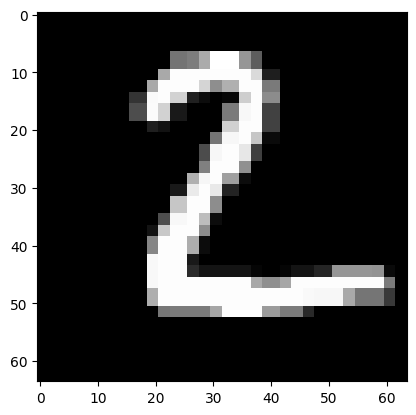

In [87]:
plt.imshow(org_image, cmap='gray')

In [88]:
adv_pred = model_custom.predict(x_test_adv)
org_pred = model_custom.predict(xb)

org_pred = np.argmax(org_pred[1])
adv_pred = np.argmax(adv_pred[1])
print(f"org_pred {org_pred} \t adv_pred {adv_pred}")

1/1 [==============================] - 0s 9ms/step
org_pred 2 	 adv_pred 6


# Batch distance measure

In [89]:
# flatten the image array as a 1D array
org_image_flattened = org_image.flatten()
adv_image_flattened = adv_image.flatten()

distance = np.linalg.norm(org_image_flattened - adv_image_flattened)
distance = round(distance, 2)
print(distance)

7.63


In [90]:
# adv_image = np.squeeze(attack_results[0][0])
# adv_image = np.expand_dims(adv_image, axis=2)
# org_image = np.expand_dims(np.squeeze(reshaped_sample_twos[0]), axis=2)
# perturbation = np.expand_dims(np.squeeze(attack_results[0][1]), axis=2)
# org_image.shape
# adv_image.shape

In [91]:
def batch_distance_measure(adv_img_arr, org_img_arr):
    l2_norm_distance = []
    for adv_img, org_img in zip(adv_img_arr, org_img_arr):
        cur_adv_img = np.array(adv_img[0])
        # print(cur_adv_img.shape)
        # print(org_img.shape)
        adv_img_flattened = cur_adv_img.flatten()
        org_img_flattened = org_image.flatten()
        distance = np.linalg.norm(org_img_flattened - adv_img_flattened)
        distance = format(distance, '.2f')
        l2_norm_distance.append(distance)
    return l2_norm_distance
        

In [92]:
l2_norm_distance = batch_distance_measure(attack_results, reshaped_sample_twos)
print(l2_norm_distance)

['7.63', '41.46', '33.63', '38.29', '35.99', '39.00', '39.38', '40.70', '42.83', '45.71']


# Visualize predictions and images

In [93]:
# fig = plt.figure(figsize=(10, 10))

# rows = 1
# columns = 3

# fig.add_subplot(rows, columns, 1)
# plt.imshow(org_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Original Image \n predictions: {org_pred}')

# fig.add_subplot(rows, columns, 2)
# plt.imshow(perturbation, cmap='gray')
# plt.axis('off')
# plt.title(f'Pertubation\n /Distance: {distance}')

# fig.add_subplot(rows, columns, 3)
# plt.imshow(adv_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Adversarial Image \n Prediction: {adv_pred}')

In [94]:
predi = model_custom.predict(reshaped_sample_twos[0])
reshaped_sample_twos[0].shape
attack_results[0][0].shape
predioo = model_custom.predict(attack_results[0][0])
print(np.argmax(predi), np.argmax(predioo))

1/1 [==============================] - 0s 10ms/step
2 6


In [95]:
def batch_visualization(adv_img_pert_arr, org_img_arr, dist_arr):
    total_plots = len(dist_arr)
    rows = total_plots
    columns = 3
    for idx in range(total_plots):
        fig = plt.figure(figsize=(10, 10))
        org_pred = model_custom.predict(reshaped_sample_twos[0])
        list_org_pred = list(org_pred)
        list_org_pred = list_org_pred[1][0]
        org_pred_cls = np.argmax(org_pred)
        org_conf = round(list_org_pred[org_pred_cls], 1)
        cur_org_img = org_img_arr[idx]
        fig.add_subplot(rows, columns, 1)
        cur_org_img_sq = np.squeeze(cur_org_img)
        plt.imshow(cur_org_img_sq, cmap='hot')
        plt.axis('off')
        plt.title(f'Original Image \n predictions: {org_pred_cls} \n ')

        cur_dist = dist_arr[idx]
        fig.add_subplot(rows, columns, 2)
        cur_pert_img = np.squeeze(perturbation)
        plt.imshow(cur_pert_img, cmap='hot')
        plt.axis('off')
        plt.title(f'Pertubation\n /Distance: {cur_dist}')

        cur_adv_img = adv_img_pert_arr[idx][0]
        adv_pred = model_custom.predict(cur_adv_img)
        adv_pred_cls = np.argmax(adv_pred)
        list_adv_pred = list(adv_pred)
        list_adv_pred = list_adv_pred[1][0]
        adv_conf = format(list_adv_pred[adv_pred_cls], '.1f')
        cur_adv_img_sq = np.squeeze(cur_adv_img)
        fig.add_subplot(rows, columns, 3)
        plt.imshow(cur_adv_img_sq, cmap='hot')
        plt.axis('off')
        plt.title(f'Adversarial Image \n Prediction: {adv_pred_cls} \n Confidence {adv_conf}')
        
    plt.show()

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


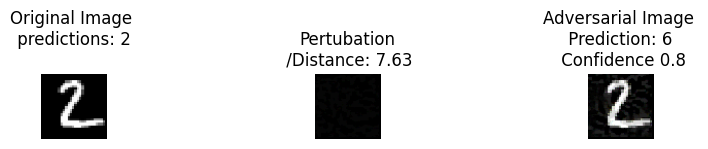

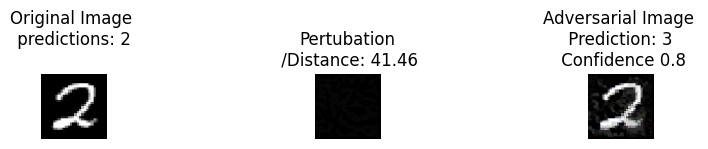

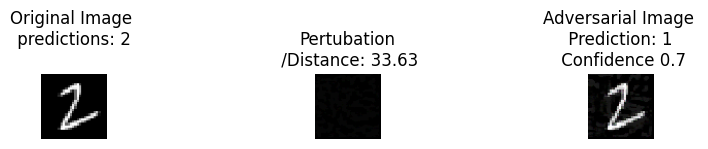

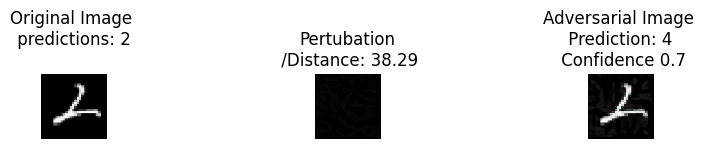

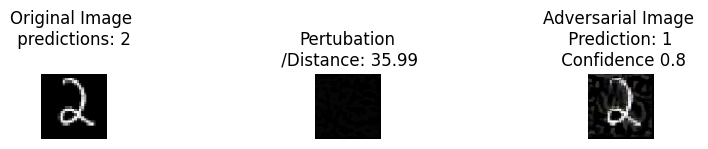

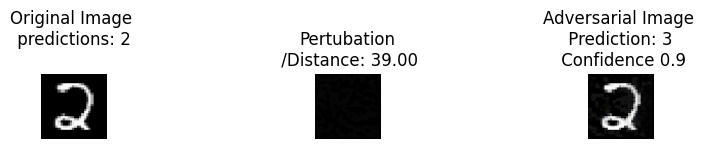

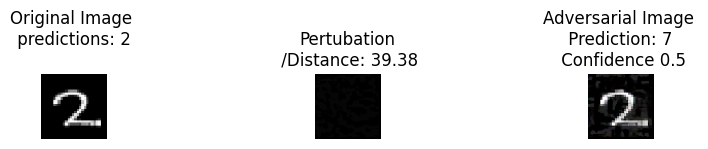

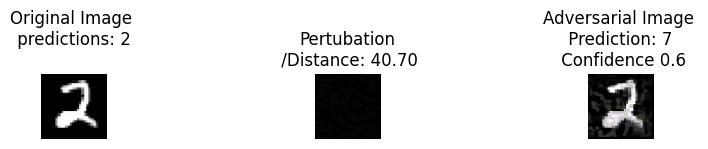

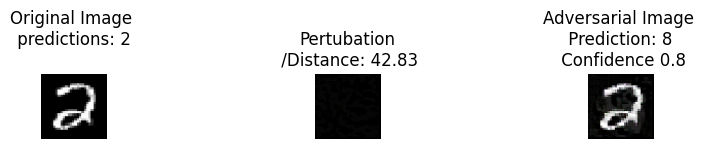

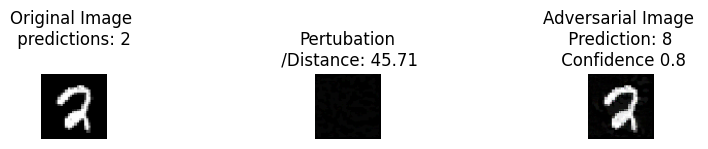

In [96]:
batch_visualization(attack_results, reshaped_sample_twos, l2_norm_distance)